In [1]:
import pandas as pd
from extract_xyz import extract_xyz
import os
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
df = pd.read_csv("Donchev et al DES370K.csv")
extract_xyz(df.head(200))

In [6]:
for c in range(len(df.columns)):
    print(c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [113]:
df.nunique()

smiles0                 356
smiles1                 215
charge0                   4
charge1                   4
natoms0                  22
natoms1                  20
system_id              3691
group_orig                4
group_id              12669
k_index                 237
geom_id              370959
cc_basis                  4
cc_HF                284368
cc_MP2_os            187230
cc_MP2_ss            185199
cc_CCSD_os           167808
cc_CCSD_ss           181314
cc_(T)               111859
cc_[T]               119545
cc_MP2_all           282988
cc_CCSD(T)_all       281724
cc_delta_CCSD(T)      98509
qz_HF                284008
qz_MP2_os            195028
qz_MP2_ss            188826
qz_MP2_all           284718
tz_HF                284131
tz_MP2_os            192538
tz_MP2_ss            187809
tz_MP2_all           283609
cbs_MP2_os           197020
cbs_MP2_ss           189972
cbs_MP2_all          284611
cbs_CCSD(T)_all      283638
espx_HF_es           268584
espx_HF_hl          

In [111]:
df.head()

,smiles0,smiles1,charge0,charge1,natoms0,natoms1,system_id,group_orig,group_id,k_index,...,sapt_disp,sapt_exdisp_os,sapt_exdisp_ss,sapt_delta_HF,sapt_all,nn_CCSD(T)_all,nn_CCSD(T)_all_05,nn_CCSD(T)_all_95,xyz,elements
0,O=CN(C)C,c1ccccc1,0,0,12,12,15948,qm_opt_dimer,1316474,-8,...,-37.15673,2.90003,4.28260,-8.26598,16.54322,21.51197,19.75058,22.52496,0.84166 -0.82674 0.4918 1.44358 -0.50149 1.505...,O C N C C H H H H H H H C C C C C C H H H H H H
1,O=CN(C)C,c1ccccc1,0,0,12,12,15948,qm_opt_dimer,1316474,-7,...,-31.54612,2.32624,3.44818,-7.14461,9.11227,13.47013,11.21334,14.27003,0.84166 -0.82674 0.4918 1.44358 -0.50149 1.505...,O C N C C H H H H H H H C C C C C C H H H H H H
2,O=CN(C)C,c1ccccc1,0,0,12,12,15948,qm_opt_dimer,1316474,-6,...,-26.81397,1.85474,2.76024,-5.93487,3.76192,7.63008,6.45529,8.37255,0.84166 -0.82674 0.4918 1.44358 -0.50149 1.505...,O C N C C H H H H H H H C C C C C C H H H H H H
3,O=CN(C)C,c1ccccc1,0,0,12,12,15948,qm_opt_dimer,1316474,-5,...,-22.82272,1.47025,2.19842,-4.77504,-0.00190,2.90708,2.19545,3.54741,0.84166 -0.82674 0.4918 1.44358 -0.50149 1.505...,O C N C C H H H H H H H C C C C C C H H H H H H
4,O=CN(C)C,c1ccccc1,0,0,12,12,15948,qm_opt_dimer,1316474,-4,...,-19.45514,1.15898,1.74336,-3.73934,-2.57027,0.25278,-0.61683,0.84849,0.84166 -0.82674 0.4918 1.44358 -0.50149 1.505...,O C N C C H H H H H H H C C C C C C H H H H H H


In [142]:
def create_newxyzs(m, item):
    ''' 
    it takes all the Hs that could be removed, it records the 1st connection and the neighbor's connections
    takes as input a Mol RDkit object of a molecule, returns a list of broken xyzs with respective parameters
    '''
    newxyzs = []
    for atom in m.GetAtoms():
        if atom.GetSymbol() == 'H':
            h = atom.GetIdx()
            ns = atom.GetNeighbors()
            if len(ns) > 1: # if not outside
                continue
            else:
                for n in ns:
                    if n.GetSymbol() in 'CNOPS':
                        organic = n.GetIdx()
                        neighbors =  [n.GetSymbol() for n in n.GetNeighbors()] 
                        # removing atom to create mol 
                        mw = Chem.RWMol(m)
                        mw.RemoveAtom(h)
                        xyz_reduced = Chem.MolToXYZBlock(mw)
                        xyz = Chem.MolToXYZBlock(m)
                        newxyzs.append([item , xyz, xyz_reduced , h , n.GetSymbol() , neighbors])
    return newxyzs

cwd = os.getcwd()
items = os.listdir()
all_xyz = []
# iterates through all generated folders and process the first xyz
for item in items:
    if os.path.isdir(item) and item != '__pycache__':
        all_xyzs = os.listdir(os.path.join(cwd, item, 'qm_opt_dimer'))
        # path to the xyz file
        xyzf = os.path.join(cwd, item, 'qm_opt_dimer', all_xyzs[0])
        xyz = os.listdir(xyzf)
        xyzp = os.path.join(cwd, item, 'qm_opt_dimer', all_xyzs[0], xyz[0])
        # open the xyz and add the bonds
        raw_mol = Chem.MolFromXYZFile(xyzp)
        mol = Chem.Mol(raw_mol)
        rdDetermineBonds.DetermineConnectivity(mol)
        m = mol
        newxyzs = create_newxyzs(m, item)  
        all_xyz.extend(newxyzs)   

all_xyz = pd.DataFrame(all_xyz, columns=['molecule_name', 'xyz','xyz_reduced', 'atom_index', 'attached_atom', 'neighboring_atoms'])
# save it 
all_xyz.to_csv('all_xyz.csv')


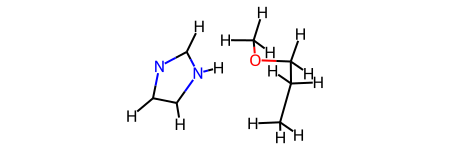

In [2]:
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds

# open the xyz and add the bonds
raw_mol = Chem.MolFromXYZFile(r"C:\Users\carlo\Dropbox\big projects dropbox\ml chem\bde\clean\remove_hs_from_dimer\bde_data\CCCOC_c1ncc[nH]1\qm_opt_dimer\405228\-1.xyz")
mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineConnectivity(mol)
m = mol
m


In [10]:
for atom in m.GetAtoms():
    print(atom.GetOwningMol(), atom.GetIdx(), atom.GetSymbol())


<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 0 C
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 1 C
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 2 C
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 3 O
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 4 C
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 5 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 6 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 7 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 8 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 9 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 10 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 11 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 12 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 13 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 14 H
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B900> 15 C
<rdkit.Chem.rdchem.Mol object at 0x0000028EC716B7B0> 16 N
<rdkit.Chem.rdchem.Mol o

In [141]:
Draw.MolToFile(m, 'whole.png')

In [140]:
from rdkit.Chem import Draw

for atom in m.GetAtoms():
    if atom.GetSymbol() == 'H':
        h = atom.GetIdx()
        ns = atom.GetNeighbors()
        if len(ns) > 1: # if not outside
            continue
        else:
            for n in ns:
                if n.GetSymbol() in 'CNOPS':
                    organic = n.GetIdx()
                    neighbors =  [n.GetSymbol() for n in n.GetNeighbors()] 
                    # removing atom to create mol 
                    mw = Chem.RWMol(m)
                    mw.RemoveAtom(h)
                    Draw.MolToFile(mw, f'{organic}.png')  

                    

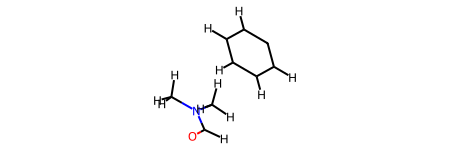

In [132]:
mw

In [38]:
print(Chem.MolToXYZBlock(mw))

23
O=CN(C)C, c1ccccc1, qm_opt_dimer, -4, 15948, 1316474, 34663397
O      0.841700   -0.826700    0.491800
C      1.443600   -0.501500    1.505500
N      1.034800    0.430700    2.407200
C      1.815300    0.748500    3.580800
C     -0.210900    1.140000    2.216900
H      2.104600    1.812900    3.581200
H      1.242400    0.539300    4.499800
H      2.731800    0.134900    3.590200
H     -0.684300    0.788000    1.284900
H     -0.903600    0.955000    3.055000
H     -0.039000    2.226500    2.135700
C      2.908900    3.876300    2.383900
C      2.044100    3.397500    1.399100
C      2.358300    2.230100    0.702300
C      3.537300    1.541500    0.990300
C      4.402100    2.020300    1.975200
C      4.087900    3.187700    2.672000
H      2.661700    4.794900    2.932200
H      1.116400    3.939300    1.172400
H      1.677800    1.853300   -0.072700
H      3.784500    0.622900    0.442000
H      5.329800    1.478500    2.201900
H      4.768400    3.564500    3.447000



: 

In [13]:
print(Chem.MolToMolBlock(mw))   

f = open("nohs.mol", "w")
f.write(Chem.MolToMolBlock(mw))
f.close()

O=CN(C)C, c1ccccc1, qm_opt_dimer, -4, 15948, 1316474, 34663397
     RDKit          3D

 23 22  0  0  0  0  0  0  0  0999 V2000
    0.8417   -0.8267    0.4918 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.4436   -0.5015    1.5055 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.0348    0.4307    2.4072 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.8153    0.7485    3.5808 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2109    1.1400    2.2169 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.1046    1.8129    3.5812 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.2424    0.5393    4.4998 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.7318    0.1349    3.5902 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6843    0.7880    1.2849 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9036    0.9550    3.0550 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0390    2.2265    2.1357 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.9089    3.8763    2.3839 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0441    3.3975    1.3991 C 

In [ ]:
# 5/2/2024
# Checking if it's only CNOPS
''' 
it takes all the Hs that could be removed, it records the 1st connection and the neighbor's connections
takes as input a Mol RDkit object of a molecule, returns a list of broken xyzs with respective parameters
'''
# checking if dimer is only made of CNOPS and H
if len(m.GetAtoms()) == len([a.GetSymbol() for a in m.GetAtoms() if a.GetSymbol() in 'CNOPSH' ]):
    
newxyzs = []
for atom in m.GetAtoms():
    if atom.GetSymbol() == 'H':
        h = atom.GetIdx()
        ns = atom.GetNeighbors()
        if len(ns) > 1: # if not outside
            continue
        else:
            for n in ns:
                if n.GetSymbol() in 'CNOPS':
                    organic = n.GetIdx()
                    neighbors =  [n.GetSymbol() for n in n.GetNeighbors()] 
                    # removing atom to create mol 
                    mw = Chem.RWMol(m)
                    mw.RemoveAtom(h)
                    xyz_reduced = Chem.MolToXYZBlock(mw)
                    xyz = Chem.MolToXYZBlock(m)
                    newxyzs.append([item , xyz, xyz_reduced , h , n.GetSymbol() , neighbors])

In [2]:
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds

path = r"C:\Users\carlo\Dropbox\big projects dropbox\ml chem\bde\clean\remove_hs_from_dimer\bde_data\CNC(=O)C_CSCSC\qm_opt_dimer\325366\0.xyz"
raw_mol = Chem.MolFromXYZFile(path)
mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineConnectivity(mol)
m = mol

In [19]:
# checking if dimer is only made f CNOPS and H
if len(m.GetAtoms()) == len([a.GetSymbol() for a in m.GetAtoms() if a.GetSymbol() in 'CNOPSH' ]):
    print('ok')

ok


In [1]:
import pandas as pd
df = pd.read_csv("Donchev et al DES15K.csv")


In [27]:
df.shape

(14651, 54)

In [2]:
from extract_xyz import extract_xyz
extract_xyz(df.head(200))

# Create folder structure

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("all_xyz.csv")

In [8]:
df.attached_atom.value_counts()/len(df)

attached_atom
C    0.910299
N    0.056478
O    0.033223
Name: count, dtype: float64

In [11]:
df.neighboring_atoms.value_counts()/len(df)

neighboring_atoms
['C', 'C', 'H']         0.199336
['S', 'H', 'H', 'H']    0.179402
['O', 'H', 'H', 'H']    0.139535
['N', 'H', 'H', 'H']    0.099668
['C', 'H', 'H', 'H']    0.098007
['S', 'S', 'H', 'H']    0.053156
['O', 'O', 'H', 'H']    0.053156
['O', 'C', 'H', 'H']    0.039867
['C', 'O', 'H', 'H']    0.026578
['C', 'N', 'H']         0.026578
['P', 'H']              0.019934
['C', 'H']              0.013289
['N', 'N', 'H']         0.013289
['N', 'C', 'H']         0.013289
['S', 'C', 'H', 'H']    0.013289
['O', 'N', 'H']         0.006645
['C', 'H', 'C']         0.004983
Name: count, dtype: float64

In [13]:
df

,Unnamed: 0,conformer,molecule_name,xyz,xyz_reduced,atom_index,attached_atom,neighboring_atoms,fragment
0,0,-4.xyz,CCO_COCOC,22\n\nC 0.768490 0.101950 -0.223790\...,21\n\nC 0.768490 0.101950 -0.223790\...,3,C,"['C', 'H', 'H', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
1,1,-4.xyz,CCO_COCOC,22\n\nC 0.768490 0.101950 -0.223790\...,21\n\nC 0.768490 0.101950 -0.223790\...,4,C,"['C', 'H', 'H', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
2,2,-4.xyz,CCO_COCOC,22\n\nC 0.768490 0.101950 -0.223790\...,21\n\nC 0.768490 0.101950 -0.223790\...,5,C,"['C', 'H', 'H', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
3,3,-4.xyz,CCO_COCOC,22\n\nC 0.768490 0.101950 -0.223790\...,21\n\nC 0.768490 0.101950 -0.223790\...,6,C,"['C', 'O', 'H', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
4,4,-4.xyz,CCO_COCOC,22\n\nC 0.768490 0.101950 -0.223790\...,21\n\nC 0.768490 0.101950 -0.223790\...,7,C,"['C', 'O', 'H', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
...,...,...,...,...,...,...,...,...,...
597,597,11.xyz,OP(=O)(O)O_c1ccccc1,20\n\nO 1.895480 4.790530 -1.263600\...,19\n\nO 1.895480 4.790530 -1.263600\...,15,C,"['C', 'C', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
598,598,11.xyz,OP(=O)(O)O_c1ccccc1,20\n\nO 1.895480 4.790530 -1.263600\...,19\n\nO 1.895480 4.790530 -1.263600\...,16,C,"['C', 'C', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
599,599,11.xyz,OP(=O)(O)O_c1ccccc1,20\n\nO 1.895480 4.790530 -1.263600\...,19\n\nO 1.895480 4.790530 -1.263600\...,17,C,"['C', 'C', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...
600,600,11.xyz,OP(=O)(O)O_c1ccccc1,20\n\nO 1.895480 4.790530 -1.263600\...,19\n\nO 1.895480 4.790530 -1.263600\...,18,C,"['C', 'C', 'H']",<rdkit.Chem.rdchem.Mol object at 0x00000290EF0...


In [11]:
import pandas as pd
import os

def writexyz(content, path_and_name):
    f = open(path_and_name, "w")
    f.write(content)
    f.close()

def folders_from_csv(path = "all_xyz.csv"):
    df = pd.read_csv(path)
    df = df.head(100)
    latest_molecule = ""
    latest_conformer = ""
    for x in df.values:
        if x[2] != latest_molecule:
            os.mkdir(x[2])
        # if change in molecule or confermer I create new conformer folder (eg if confrmer is same but molecule if different)
        if "c_" + str(x[1]).split('.')[0] != latest_conformer or x[2] != latest_molecule:
            fdr = "c_" + str(x[1]).split('.')[0]
            os.mkdir(f"{x[2]}/{fdr}")
            writexyz(x[3], f"{x[2]}/{fdr}/original.xyz")
        latest_conformer = "c_" + str(x[1]).split('.')[0]
        latest_molecule = x[2]
        writexyz(x[4], f"{latest_molecule}/{latest_conformer}/{x[5]}.xyz")
    return 0


In [12]:
folders_from_csv()

0

In [7]:
import os
# os.mkdir('hey')



In [9]:
os.mkdir("CCO_COCOC/c_-4")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'CCO_/c_-4'

In [10]:
writexyz("yooo", "CCO_COCOC/c_-4/original.xyz")

# Only keeping unique 

In [61]:


abs1 = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1sta' , 'neighborsa', 'fragment']

abs1b = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1sta' , 'neighborsa', '*']

abs2 = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1stb' , 'neighborsb', 'fragment']

abs2b = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1stb' , 'neighborsb', '*']

abs3 = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1stb' , 'neighborsc', 'fragment']

abs3b = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1stb' , 'neighborsc', '*']

In [2]:
import pandas as pd
# all_abs = [abs1, abs1b, abs1, abs2, abs2b, abs3, abs3b, abs1, abs2, abs1]

In [ ]:
all_abs = pd.DataFrame(all_abs, columns = ['conformer', 'item' , 'xyz' , 'xyz_reduced',  'h' , 
                       '1st' , 'neighbors', 'fragment'])

all_abs = all_abs.groupby(['1st', 'neighbors']).apply(lambda x: x.sample(1)).reset_index(drop=True)
all_abs = [list(x) for x in all_abs.values]

,conformer,item,xyz,xyz_reduced,h,1sta,neighborsa,fragment
0,conformer,item,xyz,xyz_reduced,h,1sta,neighborsa,fragment
1,conformer,item,xyz,xyz_reduced,h,1stb,neighborsb,*
2,conformer,item,xyz,xyz_reduced,h,1stb,neighborsc,*


In [70]:
# check how much they are reduced

In [95]:
df = pd.read_csv("all_xyz.csv")
df.shape

(907, 9)

In [94]:
df = pd.read_csv("all_xyz.csv")
df.shape

(264, 9)

In [ ]:
cwd = os.getcwd()


In [3]:
df = pd.read_csv("Donchev et al DES15K.csv")


In [107]:
os.chdir(r"C:\Users\carlo\Dropbox\big projects dropbox\ml chem\bde\clean\remove_hs_from_dimer\bde_data")

In [4]:
extract_xyz(df[:100])

In [1]:
from extract_xyz import extract_xyz

In [100]:
cwd = os.getcwd()
items = os.listdir()
cwd

'c:\\Users\\carlo\\Dropbox\\big projects dropbox\\ml chem\\bde\\clean\\remove_hs_from_dimer\\bde_data'

In [97]:
import os

In [102]:
os.chdir("xyzs")

In [103]:
os.getcwd()

'c:\\Users\\carlo\\Dropbox\\big projects dropbox\\ml chem\\bde\\clean\\remove_hs_from_dimer\\bde_data\\xyzs'